## Look at temperature-salinity relationships for the boundary condition

In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
import cmocean
from matplotlib.patches import ConnectionPatch
from math import sin, cos, sqrt, atan2, radians
from matplotlib.ticker import MultipleLocator
import gsw
import xarray as xr

%matplotlib inline

#### Parameters

In [2]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1600,imax,jmax,jmax) # Northern Canada Basin
bdy_WCB = (imax,imax,391,jmax)  # Western Canada Basin
bdy_BB  = (imin,imin,449,674)   # Baffin Bay
bdy_HB  = (1189,1474,291,291)   # Hudson Bay

In [3]:
# Colors
land_color = '#a9a7a2'

color_sBB = '#cc0e1d'# '#b0165f'
color_sGR = '#ffb7aa'#'#ff9966'

#### Files

In [4]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

Boundary Condition file:

In [5]:
BC     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC_20220322.nc','r')
dPb_S  = np.array(BC.variables['dPb_S']).reshape(50,10,225)

In [6]:
dPb_S_lons = mesh_lon[bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]] 
dPb_S_lats = mesh_lat[bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]
dPb_S_mdepths = bathy_masked[:,bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]

print('Southern boundary dimensions:     ', dPb_S.shape, dPb_S_lons.shape, dPb_S_lats.shape, dPb_S_mdepths.shape)

Southern boundary dimensions:      (50, 10, 225) (10, 225) (10, 225) (50, 10, 225)


Pb observations:

In [7]:
folder= '/ocean/brogalla/GEOTRACES/data/'

# Data from the GEOTRACES 2021 Intermediate Data Product

#------------------------- North Atlantic Ocean:--------------------------------------------------------------
df_NA = nc.Dataset(f'{folder}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_pZVh4suO.nc')
NA_lons       = np.array(df_NA.variables['longitude'])
NA_lats       = np.array(df_NA.variables['latitude'])
NA_pressure   = np.array(df_NA.variables['var1']) # pressure from CTD sensor in dbar
NA_depths     = np.array(df_NA.variables['var2']) # depth below sea surface calculated from pressure
NA_temp_C     = np.array(df_NA.variables['var3']) # temperature from CTD sensor in ITS-90 convention
NA_sal_pss78  = np.array(df_NA.variables['var4']) # practical salinity from CTD sensor in PSS-1978 scale
NA_dPb_pmolkg = np.array(df_NA.variables['var9']) # concentration of dissolved Pb in pmol/kg 

#---- unit conversions: ----
# CTD sensor pressure --> sea pressure (absolute pressure minus 10.1325 dbar); mask pressures less than atmospheric pressure
NA_sea_pressure = np.ma.masked_where(NA_pressure < -1e8, NA_pressure)
# practical salinity --> absolute salinity (g/kg)
NA_lons_tile  = np.tile(NA_lons, (301,1)).transpose()
NA_lats_tile  = np.tile(NA_lats, (301,1)).transpose()
NA_sal_abs      = gsw.conversions.SA_from_SP(NA_sal_pss78, NA_sea_pressure, NA_lons_tile, NA_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
NA_density      = gsw.density.rho_t_exact(NA_sal_abs, NA_temp_C, NA_sea_pressure) # kg/m3
# dPb in pmol/kg --> pmol/L
NA_dPb_pmolL    = np.ma.masked_where(NA_dPb_pmolkg < 0, NA_dPb_pmolkg*NA_density*1e-3)

#------------------------- Arctic Ocean:----------------------------------------------------------------------
df_AO         = nc.Dataset(f'{folder}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_iVeYJS4U.nc')
AO_lons       = np.array(df_AO.variables['longitude'])
AO_lats       = np.array(df_AO.variables['latitude'])
AO_pressure   = np.array(df_AO.variables['var1']) # pressure from CTD sensor in dbar
AO_depths     = np.array(df_AO.variables['var2']) # depth below sea surface calculated from pressure
AO_temp_C     = np.array(df_AO.variables['var3']) # temperature from CTD sensor in ITS-90 convention
AO_sal_pss78  = np.array(df_AO.variables['var4']) # practical salinity from CTD sensor in PSS-1978 scale
AO_dPb_pmolkg = np.array(df_AO.variables['var9']) # concentration of dissolved Pb in pmol/kg 
# AO_sal_pss78  = np.array(df_AO.variables['var5']) # practical salinity from bottle sample in PSS-1978 scale

#---- unit conversions: ----
# CTD sensor pressure --> sea pressure (absolute pressure minus 10.1325 dbar); mask pressures less than atmospheric pressure
AO_sea_pressure = np.ma.masked_where(AO_pressure < -1e8, AO_pressure)
# practical salinity --> absolute salinity (g/kg)
AO_lons_tile    = np.tile(AO_lons, (345,1)).transpose()
AO_lats_tile    = np.tile(AO_lats, (345,1)).transpose()
AO_sal_abs      = gsw.conversions.SA_from_SP(AO_sal_pss78, AO_sea_pressure, AO_lons_tile, AO_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
AO_density      = gsw.density.rho_t_exact(AO_sal_abs, AO_temp_C, AO_sea_pressure) # kg/m3
# dPb in pmol/kg --> pmol/L
AO_dPb_pmolL    = np.ma.masked_where(AO_dPb_pmolkg < 0, AO_dPb_pmolkg*AO_density*1e-3)
AO_depths       = np.ma.masked_where(AO_depths < 0, AO_depths)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:3071: RuntimeWarning: invalid value encountered in rho_t_exact
  return _gsw_ufuncs.rho_t_exact(SA, t, p)


In [8]:
Pb_IDP = xr.open_dataset(f'{folder}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_6JQGakpX.nc')
Sbdy_lons       = Pb_IDP['longitude'].values
Sbdy_lats       = Pb_IDP['latitude'].values
Sbdy_pressure   = Pb_IDP['var1'].values # pressure from CTD sensor in dbar
Sbdy_depths     = Pb_IDP['var2'].values # depth below sea surface calculated from pressure
Sbdy_temp_C     = Pb_IDP['var3'].values # temperature from CTD sensor in ITS-90 convention
Sbdy_sal_pss78  = Pb_IDP['var4'].values # practical salinity from CTD sensor in PSS-1978 scale
Sbdy_dPb_pmolkg = Pb_IDP['var9'].values # concentration of dissolved Pb in pmol/kg 
Sbdy_dPb_pmolkg_qc = Pb_IDP['var9_qc'].values # flag_meanings :[48 49 50 51 52]
# no_quality_control, good_value, probably_good_value, probably_bad_value, bad_value
Sbdy_dPb_pmolkg = np.ma.masked_where(Sbdy_dPb_pmolkg_qc > 50, Sbdy_dPb_pmolkg) # mask probably bad values

# Unit conversions
Sbdy_sea_pressure = np.ma.masked_where(Sbdy_pressure < -1e8, Sbdy_pressure)
# practical salinity --> absolute salinity (g/kg)
Sbdy_lons_tile    = np.tile(Sbdy_lons, (268,1)).transpose()
Sbdy_lats_tile    = np.tile(Sbdy_lats, (268,1)).transpose()
Sbdy_sal_abs      = gsw.conversions.SA_from_SP(Sbdy_sal_pss78, Sbdy_sea_pressure, Sbdy_lons_tile, Sbdy_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
Sbdy_density      = gsw.density.rho_t_exact(Sbdy_sal_abs, Sbdy_temp_C, Sbdy_sea_pressure) # kg/m3
# dPb in pmol/kg --> pmol/L
Sbdy_dPb_pmolL    = np.ma.masked_where(Sbdy_dPb_pmolkg < 0, Sbdy_dPb_pmolkg*Sbdy_density*1e-3)
Sbdy_depths       = np.ma.masked_where(Sbdy_depths < 0, Sbdy_depths)

In [9]:
print(Sbdy_lons)
print(360-48)

[319.7471  319.0946  318.7031  318.2697  317.9971  317.7621  316.9944
 317.1865  317.4802  317.6011  317.68658 317.724   317.7628  317.9874
 315.6702  314.3802  314.3263  313.9162  313.614   313.2469  312.9878
 312.5796  311.9068  311.2372  310.5667  309.1377  308.6085  308.404
 308.2396  307.4999  308.9031  306.1832  320.4904  318.4008  316.43732
 315.9453  320.2936  314.1652  314.2685  317.5531  300.9359  293.0056
 291.4005  306.63    303.4498  299.8893 ]
312


#### Functions

In [10]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [11]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [12]:
# Convert lat/lon to closest point on boundary:
def closest_bdy_point(lats, lons, bdy_lat, bdy_lon):

    bdy_ind = np.empty_like(lats)
    for stn in range(0,len(lats)):
        dist = haversine(lons[stn], lats[stn], bdy_lon, bdy_lat)
        if np.min(dist) > 500:
            bdy_ind[stn] = np.nan
        else:
            bdy_ind[stn] = np.argmin(dist)

    return bdy_ind

In [13]:
def plot_BC(axis, bdy_distance, dPb, bathy, obs_distance, obs_depths, obs_dPb, \
            xlim=(0,500), ylim=(4000, -50), vlim=(0,25), cmap=cmocean.cm.deep_r):    
    axis.invert_yaxis()
    axis.set_ylim([ylim[0], ylim[1]])
    axis.set_xlim([xlim[0], xlim[1]])
    axis.tick_params(axis='both', which='major', labelsize=6)
    
    # plot model boundary condition:
    xx, zz = np.meshgrid(bdy_distance, depths)
    CB = axis.pcolormesh(xx, zz, dPb*1e12, vmin=vlim[0], vmax=vlim[1], cmap=cmap)
    axis.pcolormesh(xx, zz, bathy, cmap=matplotlib.colors.ListedColormap([land_color]))
        
    # superimpose observations:
    try:
        axis.scatter(obs_distance, obs_depths, c=obs_dPb, vmin=vlim[0], vmax=vlim[1], edgecolor='w', \
                     cmap=cmap, s=15, linewidth=0.2)
    except:
        pass

    return CB

In [85]:
def plot_density_lines(ax):
    
    density_range     = np.arange(1020,1031,0.5)
    temperature_range = np.linspace(-3,8,20)
    salinity_grid     = np.empty((len(density_range),len(temperature_range)))

    for d,density in enumerate(density_range):
        for t,temperature in enumerate(temperature_range):
            salinity_grid[d,t] = gsw.conversions.SA_from_rho(density, temperature, 0) # sea level pressure in dbar

    temperature_grid, density_grid = np.meshgrid(temperature_range, density_range)
    
    CS = ax.contour(salinity_grid, temperature_grid, density_grid, colors='#717372', levels=20, linestyles='--', linewidths=0.3, zorder=1)    
    ax.clabel(CS, levels=[1023, 1024, 1025, 1026, 1027, 1028], fontsize=4.5, fmt='%.f', \
          manual=[(29,-2),(30.5,-2),(31.5,-2),(32.5,-2),(33.5,-2),(35,-2)])
    
    return


#### Calculations

In [14]:
# Look at only one slice of the rimwidth thickness boundary:
S_distance  = calc_distance(dPb_S_lats[-1,:]   , dPb_S_lons[-1,:])

In [15]:
# Find index along boundary of the observations
BB_bdy_ind  = closest_bdy_point(NA_lats, NA_lons, dPb_S_lats[-1,:], dPb_S_lons[-1,:])
    
# North Atlantic obs
BB_obs_distance = np.empty(NA_lons.shape); BB_obs_distance[:]=np.nan;
for ind_n in range(0,len(NA_lons)):
    if np.isnan(BB_bdy_ind[ind_n]):
        BB_obs_distance[ind_n] = np.nan
    else:
        BB_obs_distance[ind_n] = S_distance[int(BB_bdy_ind[ind_n])]

#### Labrador Sea boundary

Show T-S cross section to check the extent of the west greenland current. Chose to compare with 2014 since that is the year of the GA01 cruis of the North Atlantic.

In [16]:
# load year 2015 climatology of ANHA12 gridT file:
df_gridT = nc.Dataset('/data/brogalla/ANHA12/gridT_2015_climatology_08.nc')

bdy_temp = np.array(df_gridT.variables['votemper'])[0,:,bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]
bdy_sal  = np.array(df_gridT.variables['vosaline'])[0,:,bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]
bdy_dens = gsw.density.sigma0(bdy_sal, bdy_temp)
bdy_dens[bdy_dens < 0] = 0

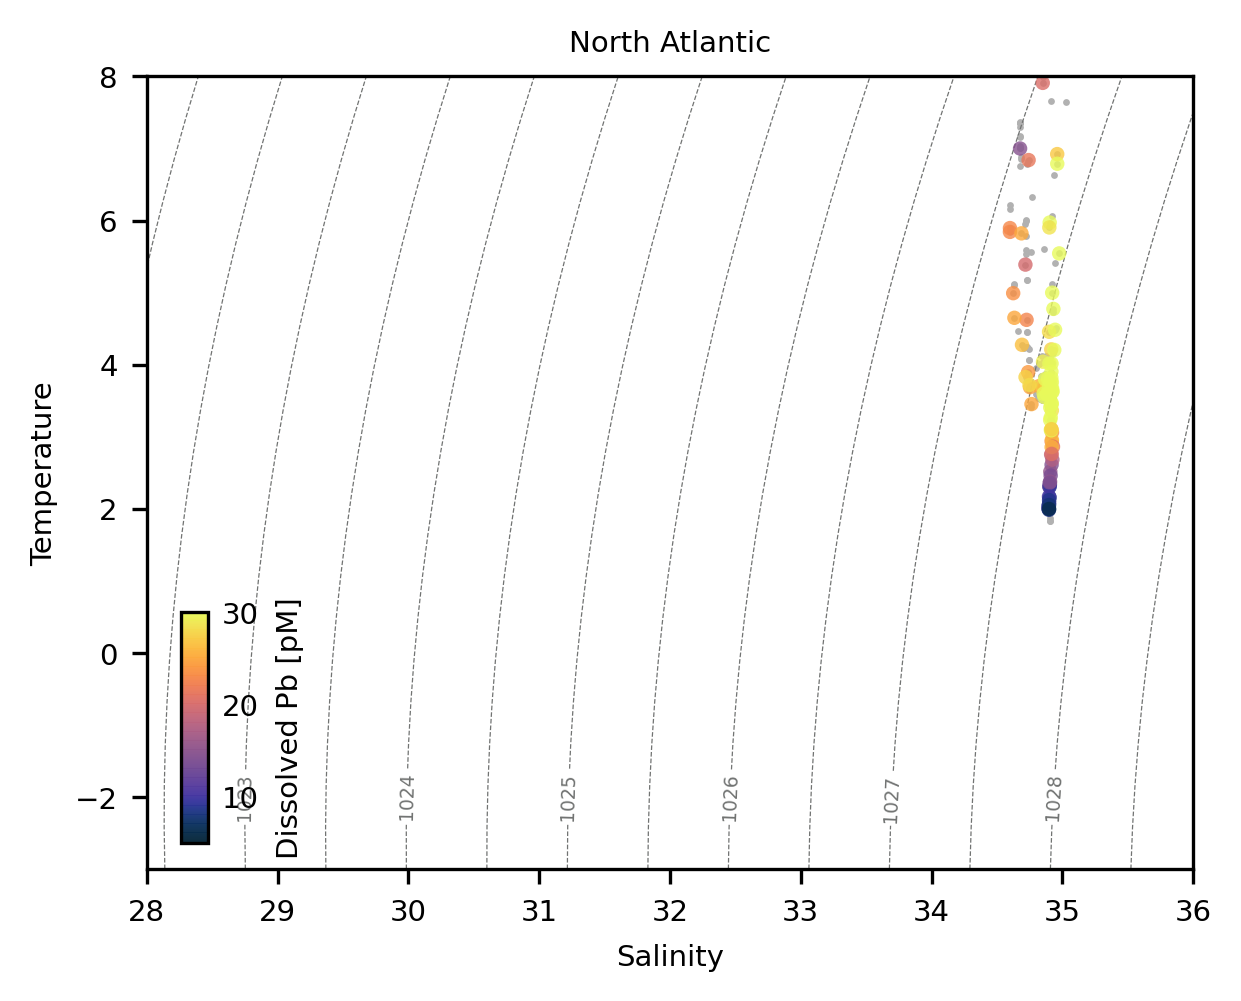

In [86]:
# Figure of TS based on labrador sea and baffin bay observations
fig, ax = plt.subplots(1,1, figsize=(4.5,3.5), dpi=300)

layer=0

# sal_plot  = np.ma.masked_where((Sbdy_lons_tile > 315), Sbdy_sal_pss78) 
# temp_plot = np.ma.masked_where((Sbdy_lons_tile > 315), Sbdy_temp_C) 
# dPb_plot  = np.ma.masked_where((Sbdy_lons_tile > 315), Sbdy_dPb_pmolL) 
sal_plot  = np.ma.masked_where((Sbdy_lons_tile < 310), Sbdy_sal_pss78) 
temp_plot = np.ma.masked_where((Sbdy_lons_tile < 310), Sbdy_temp_C) 
dPb_plot  = np.ma.masked_where((Sbdy_lons_tile < 310), Sbdy_dPb_pmolL) 
sal_plot  = np.ma.masked_where((Sbdy_lats_tile > 55), sal_plot)
temp_plot = np.ma.masked_where((Sbdy_lats_tile > 55), temp_plot)
dPb_plot  = np.ma.masked_where((Sbdy_lats_tile > 55), dPb_plot)

ax.scatter(sal_plot.flatten(), temp_plot.flatten(), c='#b1b1b1', s=0.4, zorder=1, alpha=1)

CB1 = ax.scatter(sal_plot.flatten(), temp_plot.flatten(), c=dPb_plot, \
           alpha=0.8, s=12, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)

ax.set_title('North Atlantic', fontsize=7)
ax.set_ylabel('Temperature', fontsize=7)
ax.set_xlabel('Salinity', fontsize=7)    
ax.set_xlim(28, 36)
ax.set_ylim(-3, 8)
ax.tick_params(axis='both', labelsize=7)

cbaxes = fig.add_axes([0.15, 0.15, 0.02, 0.22]);
CBar   = plt.colorbar(CB1, ax=ax, cax=cbaxes); 
CBar.set_label('Dissolved Pb [pM]', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

plot_density_lines(ax)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/TS_observations_NA.jpg', dpi=300)

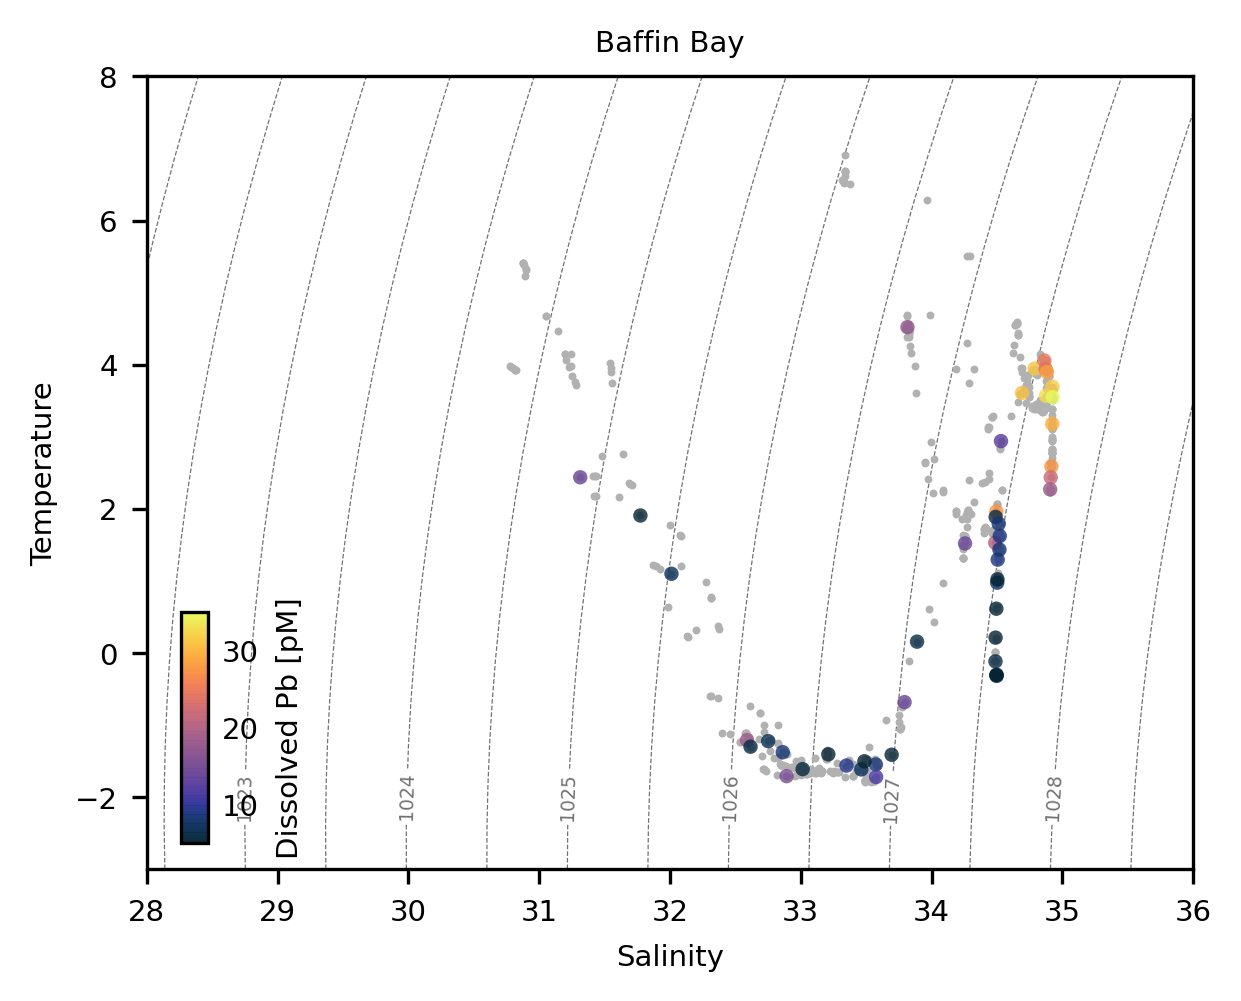

In [88]:
# Figure of TS based on labrador sea and baffin bay observations
fig, ax = plt.subplots(1,1, figsize=(4.5,3.5), dpi=300)

layer=0

sal_plot  = np.ma.masked_where((Sbdy_lons_tile > 310), Sbdy_sal_pss78) 
temp_plot = np.ma.masked_where((Sbdy_lons_tile > 310), Sbdy_temp_C) 
dPb_plot  = np.ma.masked_where((Sbdy_lons_tile > 310), Sbdy_dPb_pmolL) 
sal_plot  = np.ma.masked_where((Sbdy_lats_tile < 55), sal_plot)
temp_plot = np.ma.masked_where((Sbdy_lats_tile < 55), temp_plot)
dPb_plot  = np.ma.masked_where((Sbdy_lats_tile < 55), dPb_plot)

ax.scatter(sal_plot.flatten(), temp_plot.flatten(), c='#b1b1b1', s=0.8, zorder=2, alpha=1)

CB1 = ax.scatter(sal_plot.flatten(), temp_plot.flatten(), c=dPb_plot, \
           alpha=0.8, s=12, edgecolor='k', linewidth=0.0, zorder=3, vmin=5, vmax=35, cmap=cmocean.cm.thermal)

ax.set_title('Baffin Bay', fontsize=7)
ax.set_ylabel('Temperature', fontsize=7)
ax.set_xlabel('Salinity', fontsize=7)    
ax.set_xlim(28, 36)
ax.set_ylim(-3, 8)
ax.tick_params(axis='both', labelsize=7)

cbaxes = fig.add_axes([0.15, 0.15, 0.02, 0.22]);
CBar   = plt.colorbar(CB1, ax=ax, cax=cbaxes); 
CBar.set_label('Dissolved Pb [pM]', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

plot_density_lines(ax)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/TS_observations_BB.jpg', dpi=300)

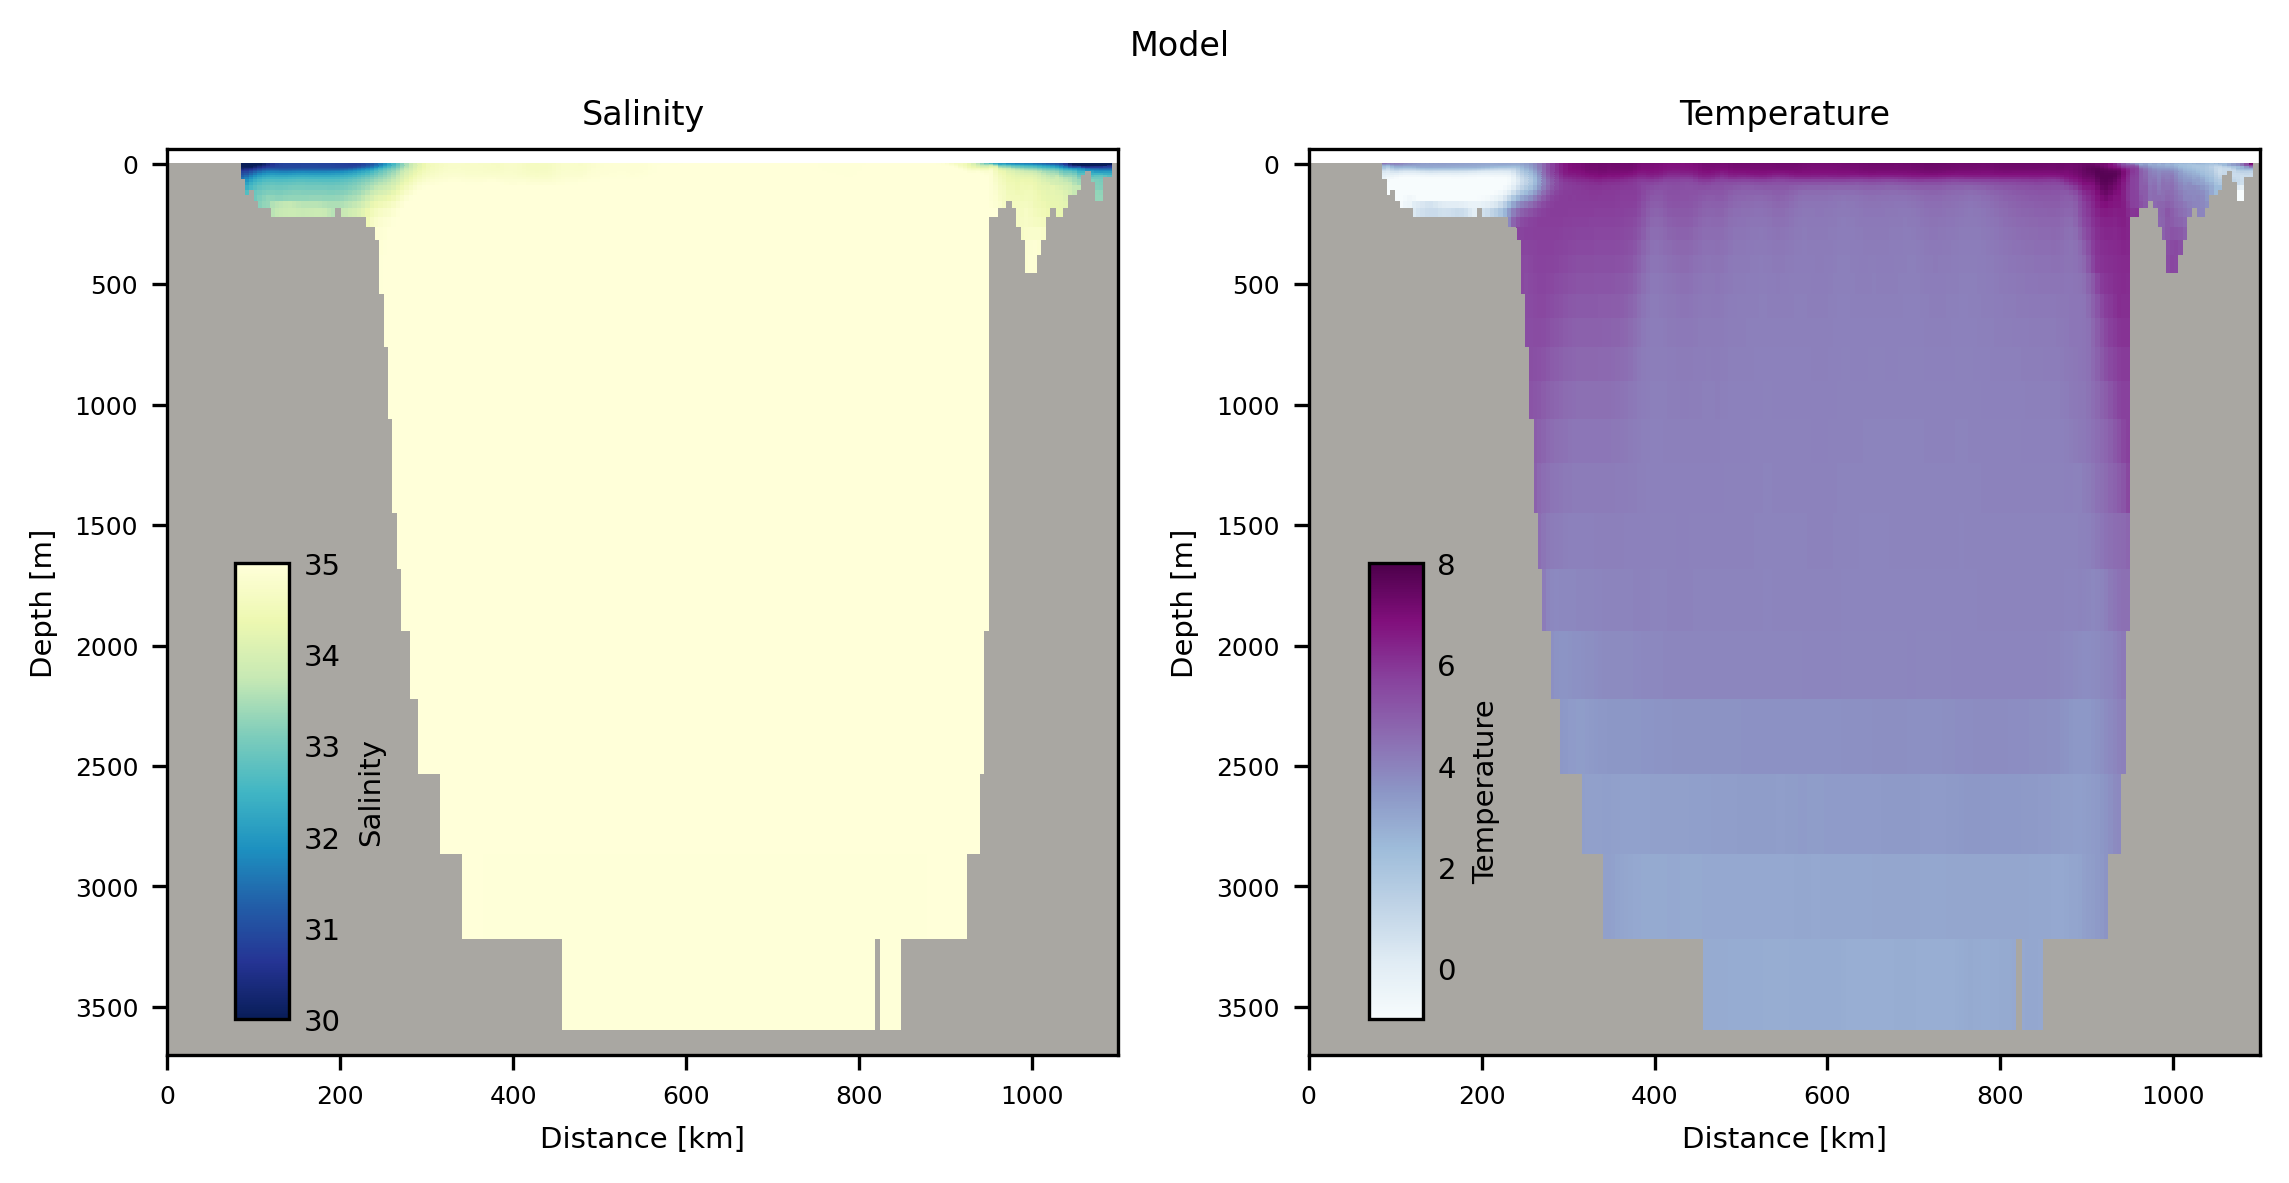

In [16]:
fig, ax = plt.subplots(1,2, figsize=(9, 4), dpi=300)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(3700, -60)
    axis.set_xlim(0, 1100)
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlabel('Distance [km]', fontsize=7)
    axis.set_ylabel('Depth [m]', fontsize=7)
    
ax[0].set_title('Salinity', fontsize=8)
ax[1].set_title('Temperature', fontsize=8)
fig.suptitle('Model', fontsize=8)

# plot model boundary condition:
bdy_cell = 0
xx, zz = np.meshgrid(S_distance, depths)
CB1 = ax[0].pcolormesh(xx, zz, bdy_sal[:,bdy_cell,:], vmin=30, vmax=35, cmap=matplotlib.cm.get_cmap('YlGnBu_r'))
ax[0].pcolormesh(xx, zz, dPb_S_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))

# plot T, S for model
xx, zz = np.meshgrid(S_distance, depths)
CB2 = ax[1].pcolormesh(xx, zz, bdy_temp[:,bdy_cell,:], vmin=-1, vmax=8, cmap=matplotlib.cm.get_cmap('BuPu'))
ax[1].pcolormesh(xx, zz, dPb_S_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))

cbaxes = fig.add_axes([0.15, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB1, ax=ax[1], cax=cbaxes); 
CBar.set_label('Salinity', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

cbaxes = fig.add_axes([0.57, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB2, ax=ax[1], cax=cbaxes); 
CBar.set_label('Temperature', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

![](../forcing/sp-2019-00083a_0004.jpeg)

At a particular location, there is not that much variation over the boundary thickness, but a lot along the transect. I don't think I can specifically identify Arctic outflow waters based on the T-S diagram, but I can identify Baffin Bay deep water and hopefully West Greenland Irminger Water. Shape of T-S diagram profiles changes rapidly over the slope region (indices 45-60). General sections of TS diagram based on indices:
- 0:45 --- western shelf (off Labrador)
- 45:60 --- western slope
- 60:180 --- central Baffin Bay
- 180:202 --- eastern slope
- 202:225 --- Greenland shelf

In [91]:
def plot_TS_grid(variable, top=0, bottom=49, savefig=''):
        
    fig, ax = plt.subplots(2,3, figsize=(9.5,6), dpi=300)

    layer=0
    var_plot = variable[top:bottom,layer,:]
    
    for axis in ax.ravel():
        axis.scatter(bdy_sal[:,layer,:], bdy_temp[:,layer,:], c='#b1b1b1', s=0.2, zorder=1, alpha=1)

        axis.set_xlim(28, 36)
        axis.set_ylim(-3, 8)
        axis.tick_params(axis='both', labelsize=7)

        plot_density_lines(axis)

    fig.suptitle(f'Depths: {depths[top]:.0f}-{depths[bottom]:.0f} m', fontsize=9)
    CB1 = ax[0,0].scatter(bdy_sal[top:bottom,layer,:], bdy_temp[top:bottom,layer,:]      , c=var_plot[:,:], \
                    alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
    ax[0,1].scatter(bdy_sal[top:bottom,layer,0:45]   , bdy_temp[top:bottom,layer,0:45]   , c=var_plot[:,0:45], \
                    alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
    ax[0,2].scatter(bdy_sal[top:bottom,layer,45:60]  , bdy_temp[top:bottom,layer,45:60]  , c=var_plot[:,45:60], \
                    alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
    ax[1,0].scatter(bdy_sal[top:bottom,layer,60:180] , bdy_temp[top:bottom,layer,60:180] , c=var_plot[:,60:180], \
                    alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
    ax[1,1].scatter(bdy_sal[top:bottom,layer,180:202], bdy_temp[top:bottom,layer,180:202], c=var_plot[:,180:202], \
                    alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
    ax[1,2].scatter(bdy_sal[top:bottom,layer,202:225], bdy_temp[top:bottom,layer,202:225], c=var_plot[:,202:225], \
                    alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)

    ax[0,0].set_title('All', fontsize=7)
    ax[0,1].set_title('Labrador shelf', fontsize=7)
    ax[0,2].set_title('Labrador-Baffin Bay slope', fontsize=7)
    ax[1,0].set_title('Central Baffin Bay', fontsize=7)
    ax[1,1].set_title('Greenland slope', fontsize=7)
    ax[1,2].set_title('Greenland shelf', fontsize=7)

    for axis in ax[:,0]:
        axis.set_ylabel('Temperature', fontsize=7)
    for axis in ax[1,:]:
        axis.set_xlabel('Salinity', fontsize=7)

    cbaxes = fig.add_axes([0.13, 0.135, 0.02, 0.22]);
    CBar   = plt.colorbar(CB1, ax=ax[1,0], cax=cbaxes); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)

    if savefig != '':
        fig.savefig(f'/ocean/brogalla/GEOTRACES/figures/Pb_explorations/{name}', dpi=300)
    return

In [92]:
plot_TS_grid(dPb_S, top=0, bottom=49) #savefig='TS_southern_bdy.jpg')

UnboundLocalError: local variable 'layer' referenced before assignment

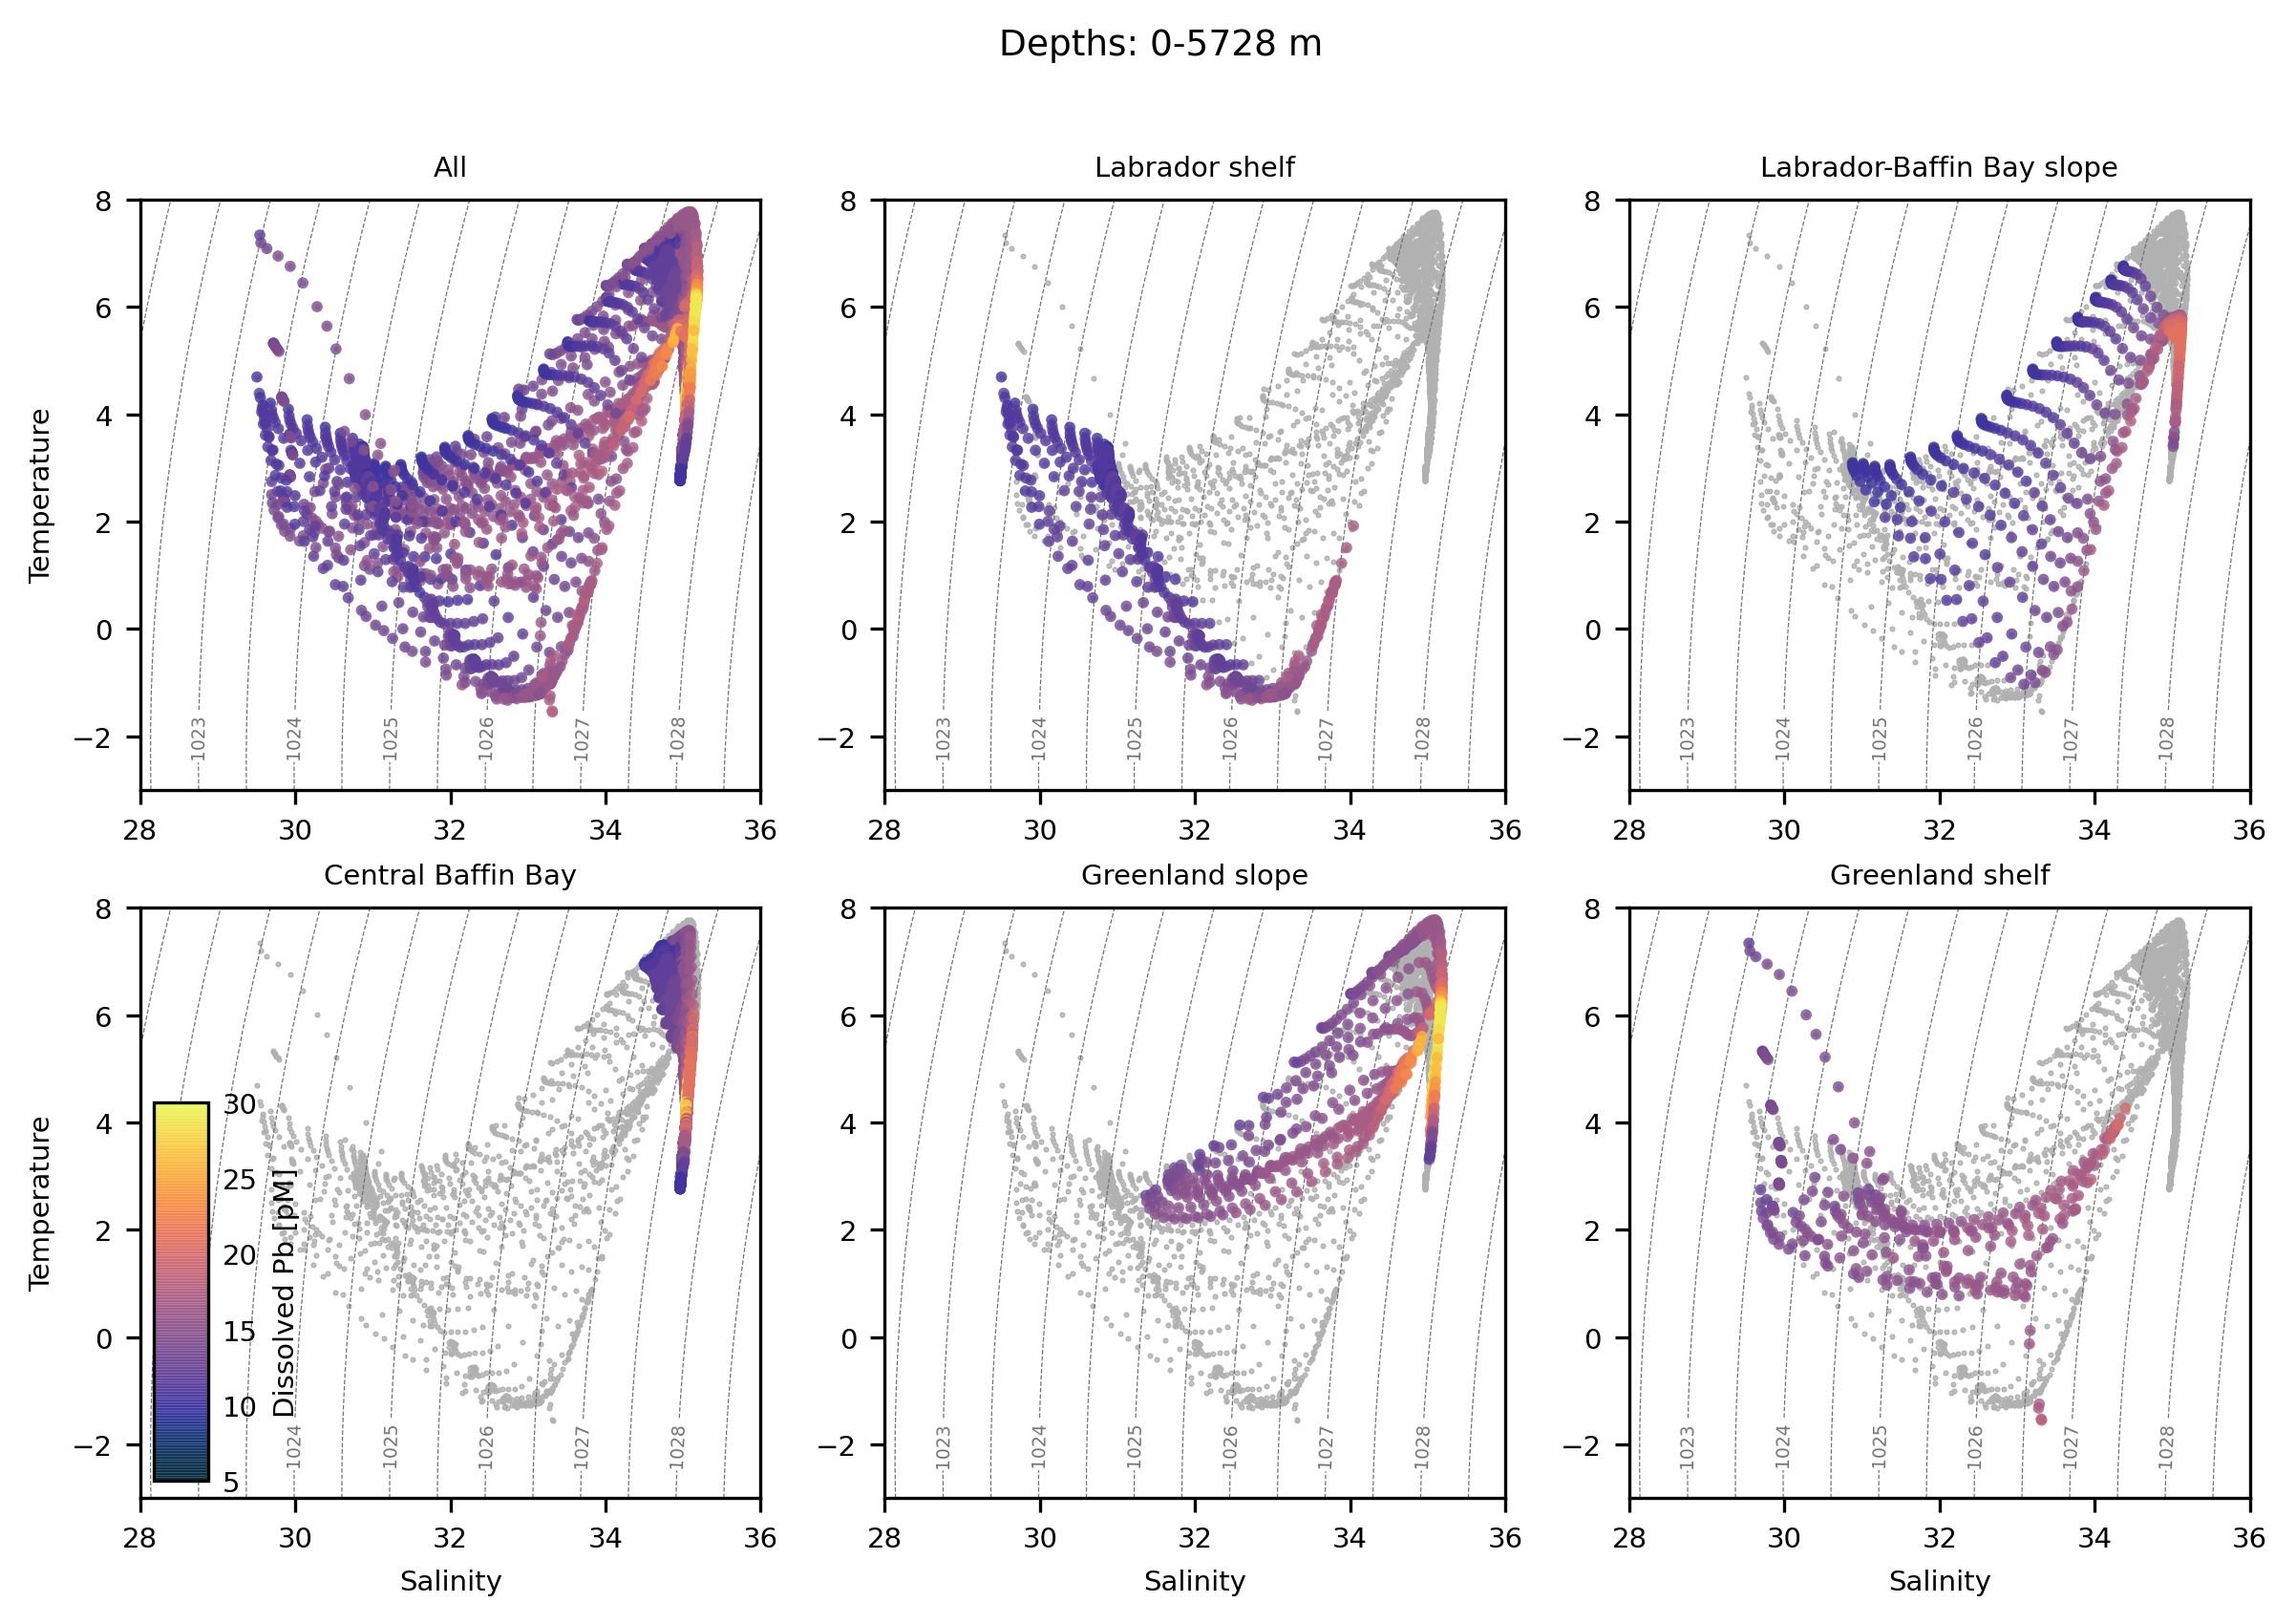

In [89]:
fig, ax = plt.subplots(2,3, figsize=(9.5,6), dpi=300)

layer=0

for axis in ax.ravel():
    axis.scatter(bdy_sal[:,layer,:], bdy_temp[:,layer,:], c='#b1b1b1', s=0.2, zorder=1, alpha=1)
    
    axis.set_xlim(28, 36)
    axis.set_ylim(-3, 8)
    axis.tick_params(axis='both', labelsize=7)
    
    plot_density_lines(axis)

top = 0
bottom = 49
fig.suptitle(f'Depths: {depths[top]:.0f}-{depths[bottom]:.0f} m', fontsize=9)
CB1 = ax[0,0].scatter(bdy_sal[top:bottom,layer,:]      , bdy_temp[top:bottom,layer,:]      , c=dPb_S[top:bottom,layer,:]*1e12      , \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
ax[0,1].scatter(bdy_sal[top:bottom,layer,0:45]   , bdy_temp[top:bottom,layer,0:45]   , c=dPb_S[top:bottom,layer,0:45]*1e12   , \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
ax[0,2].scatter(bdy_sal[top:bottom,layer,45:60]  , bdy_temp[top:bottom,layer,45:60]  , c=dPb_S[top:bottom,layer,45:60]*1e12  , \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
ax[1,0].scatter(bdy_sal[top:bottom,layer,60:180] , bdy_temp[top:bottom,layer,60:180] , c=dPb_S[top:bottom,layer,60:180]*1e12 , \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
ax[1,1].scatter(bdy_sal[top:bottom,layer,180:202], bdy_temp[top:bottom,layer,180:202], c=dPb_S[top:bottom,layer,180:202]*1e12, \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
ax[1,2].scatter(bdy_sal[top:bottom,layer,202:225], bdy_temp[top:bottom,layer,202:225], c=dPb_S[top:bottom,layer,202:225]*1e12, \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)

ax[0,0].set_title('All', fontsize=7)
ax[0,1].set_title('Labrador shelf', fontsize=7)
ax[0,2].set_title('Labrador-Baffin Bay slope', fontsize=7)
ax[1,0].set_title('Central Baffin Bay', fontsize=7)
ax[1,1].set_title('Greenland slope', fontsize=7)
ax[1,2].set_title('Greenland shelf', fontsize=7)

for axis in ax[:,0]:
    axis.set_ylabel('Temperature', fontsize=7)
for axis in ax[1,:]:
    axis.set_xlabel('Salinity', fontsize=7)

cbaxes = fig.add_axes([0.13, 0.135, 0.02, 0.22]);
CBar   = plt.colorbar(CB1, ax=ax[1,0], cax=cbaxes); 
CBar.set_label('Dissolved Pb [pM]', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/TS_southern_bdy.jpg', dpi=300)

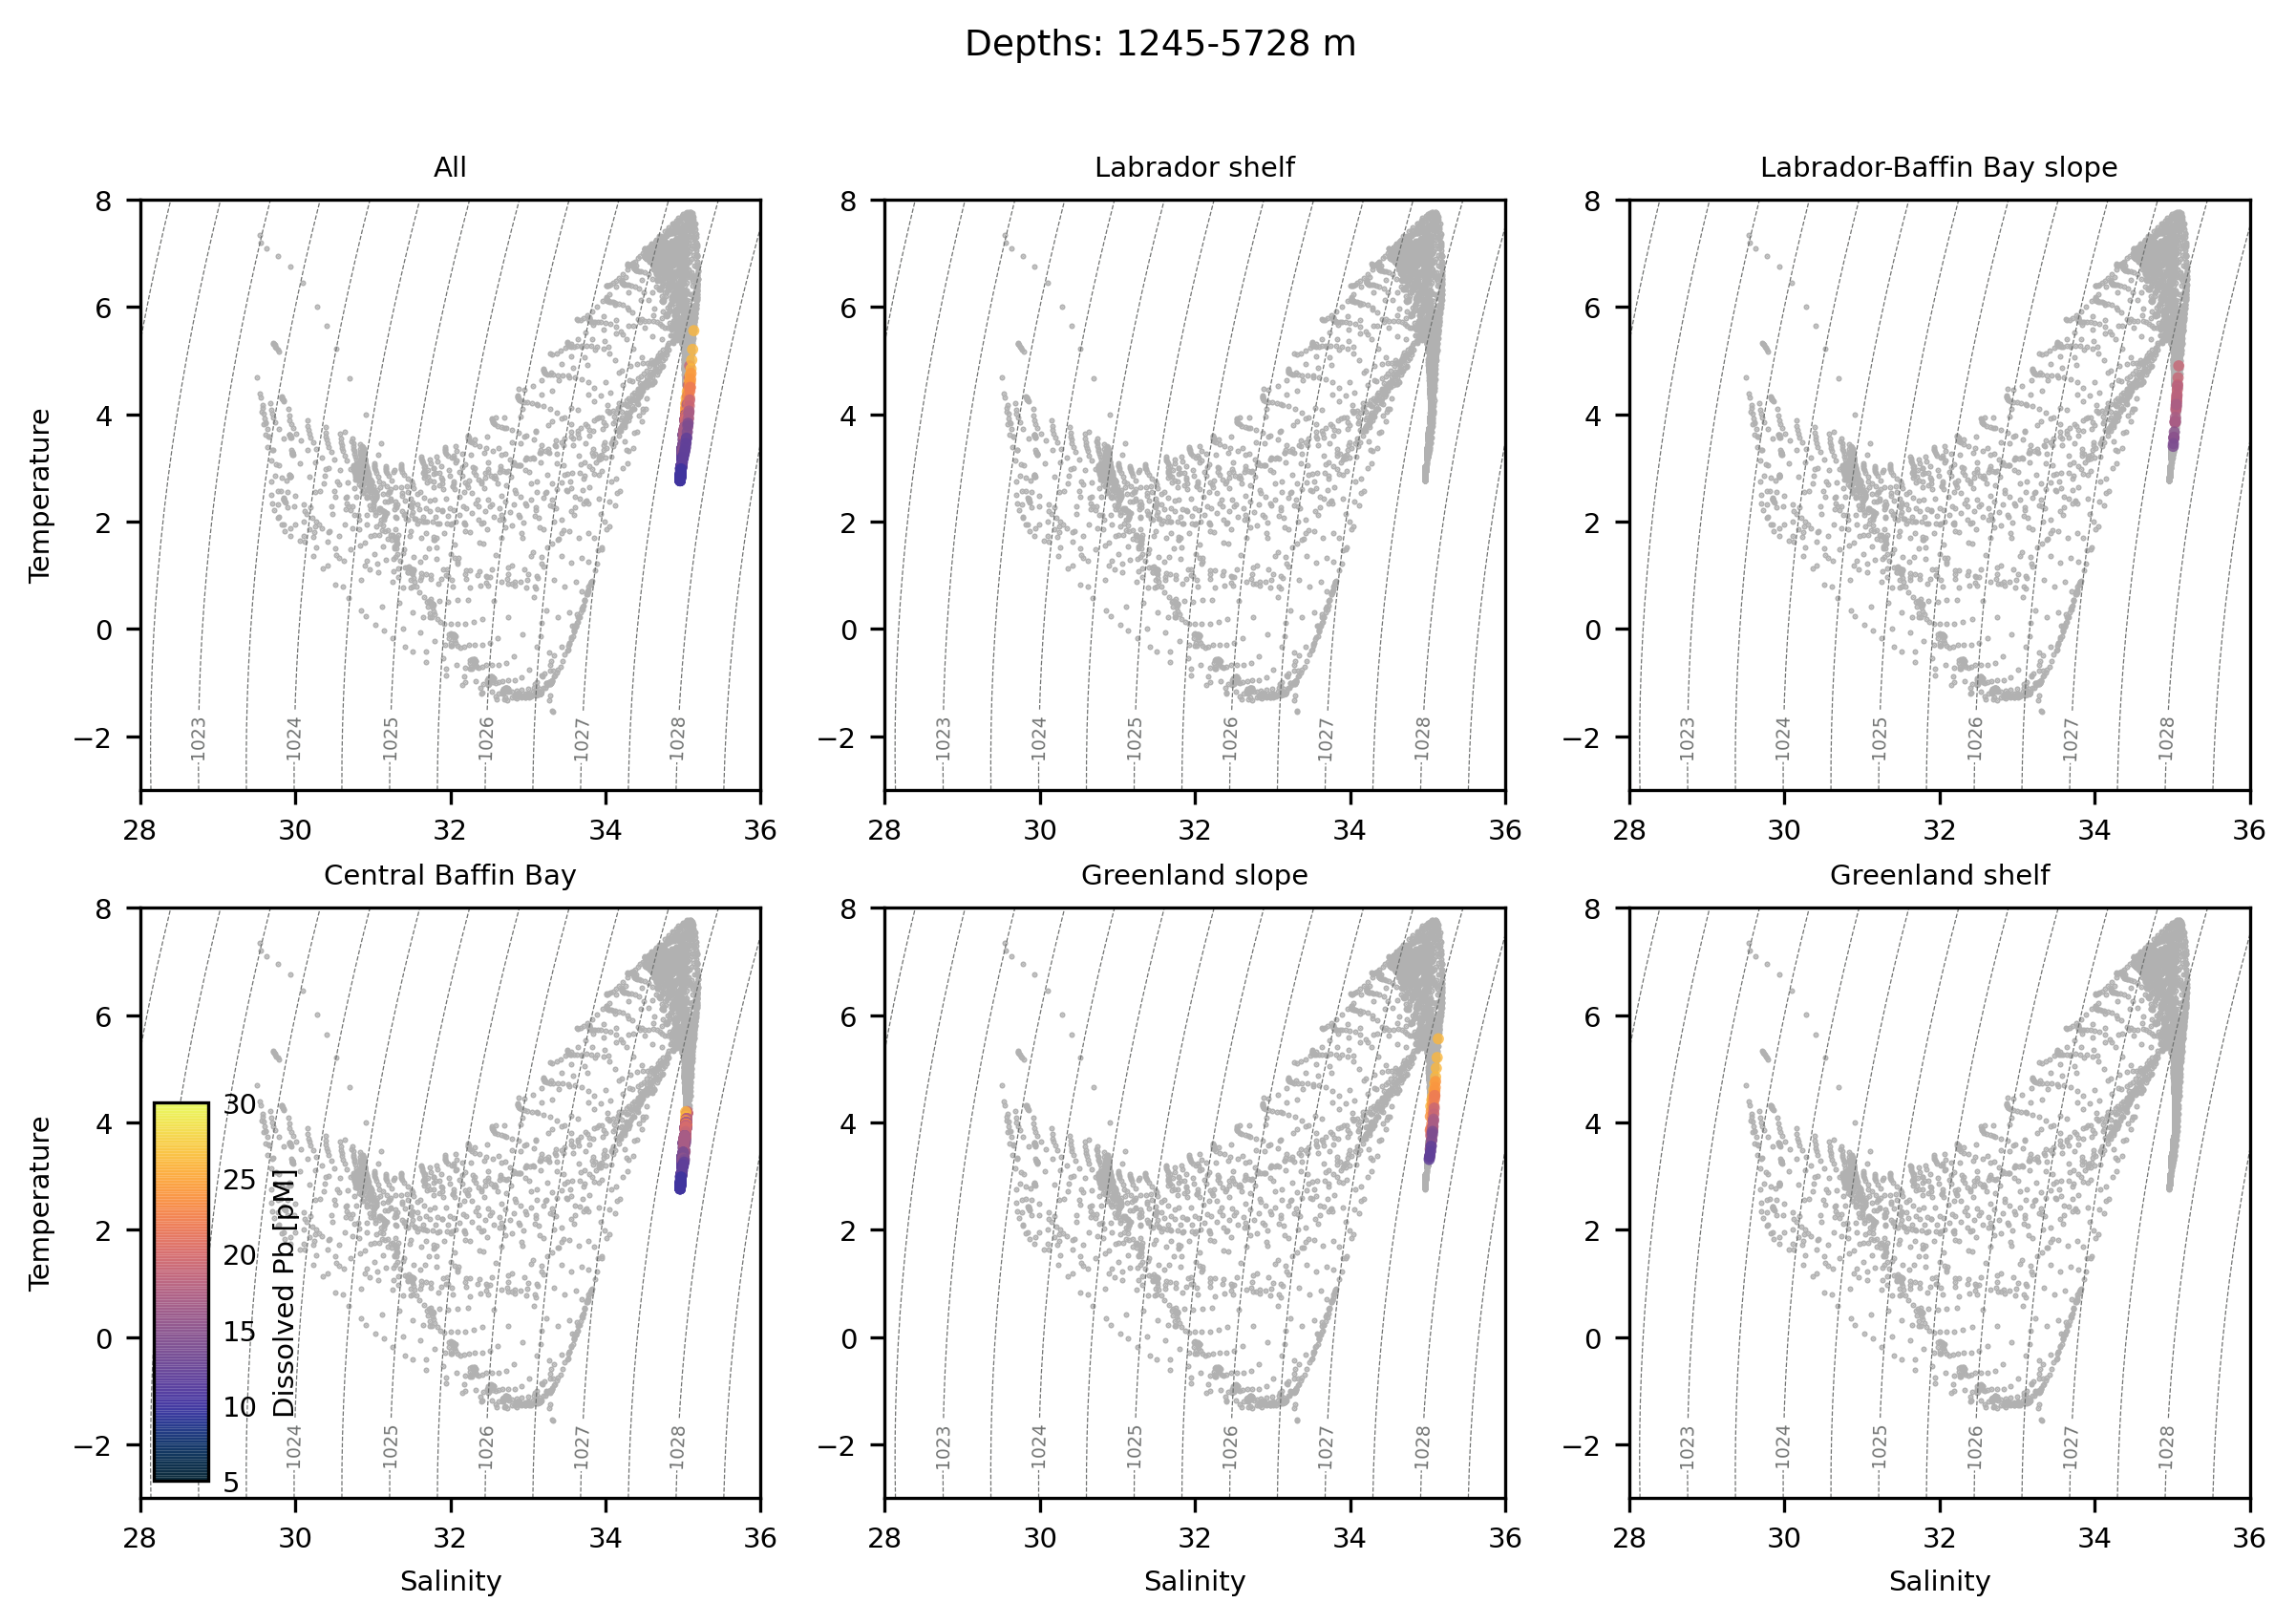

In [90]:
fig, ax = plt.subplots(2,3, figsize=(9.5,6), dpi=300)

layer=0

for axis in ax.ravel():
    axis.scatter(bdy_sal[:,layer,:], bdy_temp[:,layer,:], c='#b1b1b1', s=0.2, zorder=1, alpha=1)
    
    axis.set_xlim(28, 36)
    axis.set_ylim(-3, 8)
    axis.tick_params(axis='both', labelsize=7)
    plot_density_lines(axis)

top = 36
bottom = 49
fig.suptitle(f'Depths: {depths[top]:.0f}-{depths[bottom]:.0f} m', fontsize=9)
CB1 = ax[0,0].scatter(bdy_sal[top:bottom,layer,:]      , bdy_temp[top:bottom,layer,:]      , c=dPb_S[top:bottom,layer,:]*1e12      , \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
ax[0,1].scatter(bdy_sal[top:bottom,layer,0:45]   , bdy_temp[top:bottom,layer,0:45]   , c=dPb_S[top:bottom,layer,0:45]*1e12   , \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
ax[0,2].scatter(bdy_sal[top:bottom,layer,45:60]  , bdy_temp[top:bottom,layer,45:60]  , c=dPb_S[top:bottom,layer,45:60]*1e12  , \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
ax[1,0].scatter(bdy_sal[top:bottom,layer,60:180] , bdy_temp[top:bottom,layer,60:180] , c=dPb_S[top:bottom,layer,60:180]*1e12 , \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
ax[1,1].scatter(bdy_sal[top:bottom,layer,180:202], bdy_temp[top:bottom,layer,180:202], c=dPb_S[top:bottom,layer,180:202]*1e12, \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)
ax[1,2].scatter(bdy_sal[top:bottom,layer,202:225], bdy_temp[top:bottom,layer,202:225], c=dPb_S[top:bottom,layer,202:225]*1e12, \
                alpha=0.8, s=8, edgecolor='k', linewidth=0.0, zorder=2, vmin=5, vmax=30, cmap=cmocean.cm.thermal)

ax[0,0].set_title('All', fontsize=7)
ax[0,1].set_title('Labrador shelf', fontsize=7)
ax[0,2].set_title('Labrador-Baffin Bay slope', fontsize=7)
ax[1,0].set_title('Central Baffin Bay', fontsize=7)
ax[1,1].set_title('Greenland slope', fontsize=7)
ax[1,2].set_title('Greenland shelf', fontsize=7)

for axis in ax[:,0]:
    axis.set_ylabel('Temperature', fontsize=7)
for axis in ax[1,:]:
    axis.set_xlabel('Salinity', fontsize=7)

cbaxes = fig.add_axes([0.13, 0.135, 0.02, 0.22]);
CBar   = plt.colorbar(CB1, ax=ax[1,0], cax=cbaxes); 
CBar.set_label('Dissolved Pb [pM]', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/TS_southern_bdy-deep.jpg', dpi=300)

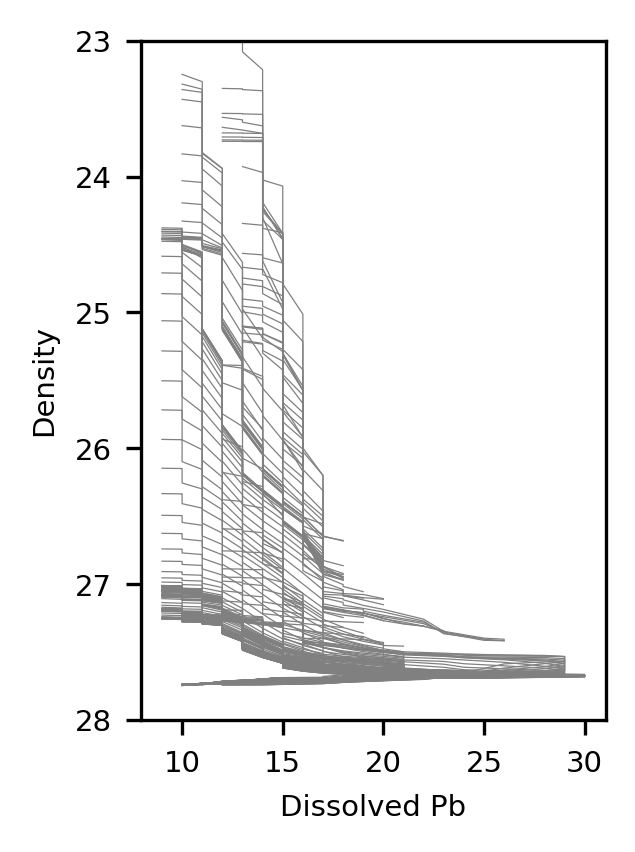

In [161]:
fig, ax = plt.subplots(1,1, figsize=(2,3), dpi=300)

ax.invert_yaxis()
ax.set_ylabel('Density', fontsize=7)
ax.set_xlabel('Dissolved Pb', fontsize=7)
ax.tick_params(axis='both', labelsize=7)
ax.set_ylim(28,23)

bdy_cell=0
dPb_profile  = np.ma.masked_where(dPb_S[:,bdy_cell,:] <=0, dPb_S[:,bdy_cell,:])
dens_profile = np.ma.masked_where(bdy_dens[:,bdy_cell,:] <=0, bdy_dens[:,bdy_cell,:])

for cell in range(0,dPb_profile.shape[1]):
    ax.plot(dPb_profile[:,cell]*1e12, dens_profile[:,cell], linewidth=0.3, c='gray')
    
# ax.scatter(dPb_profile*1e12, dens_profile, s=2)

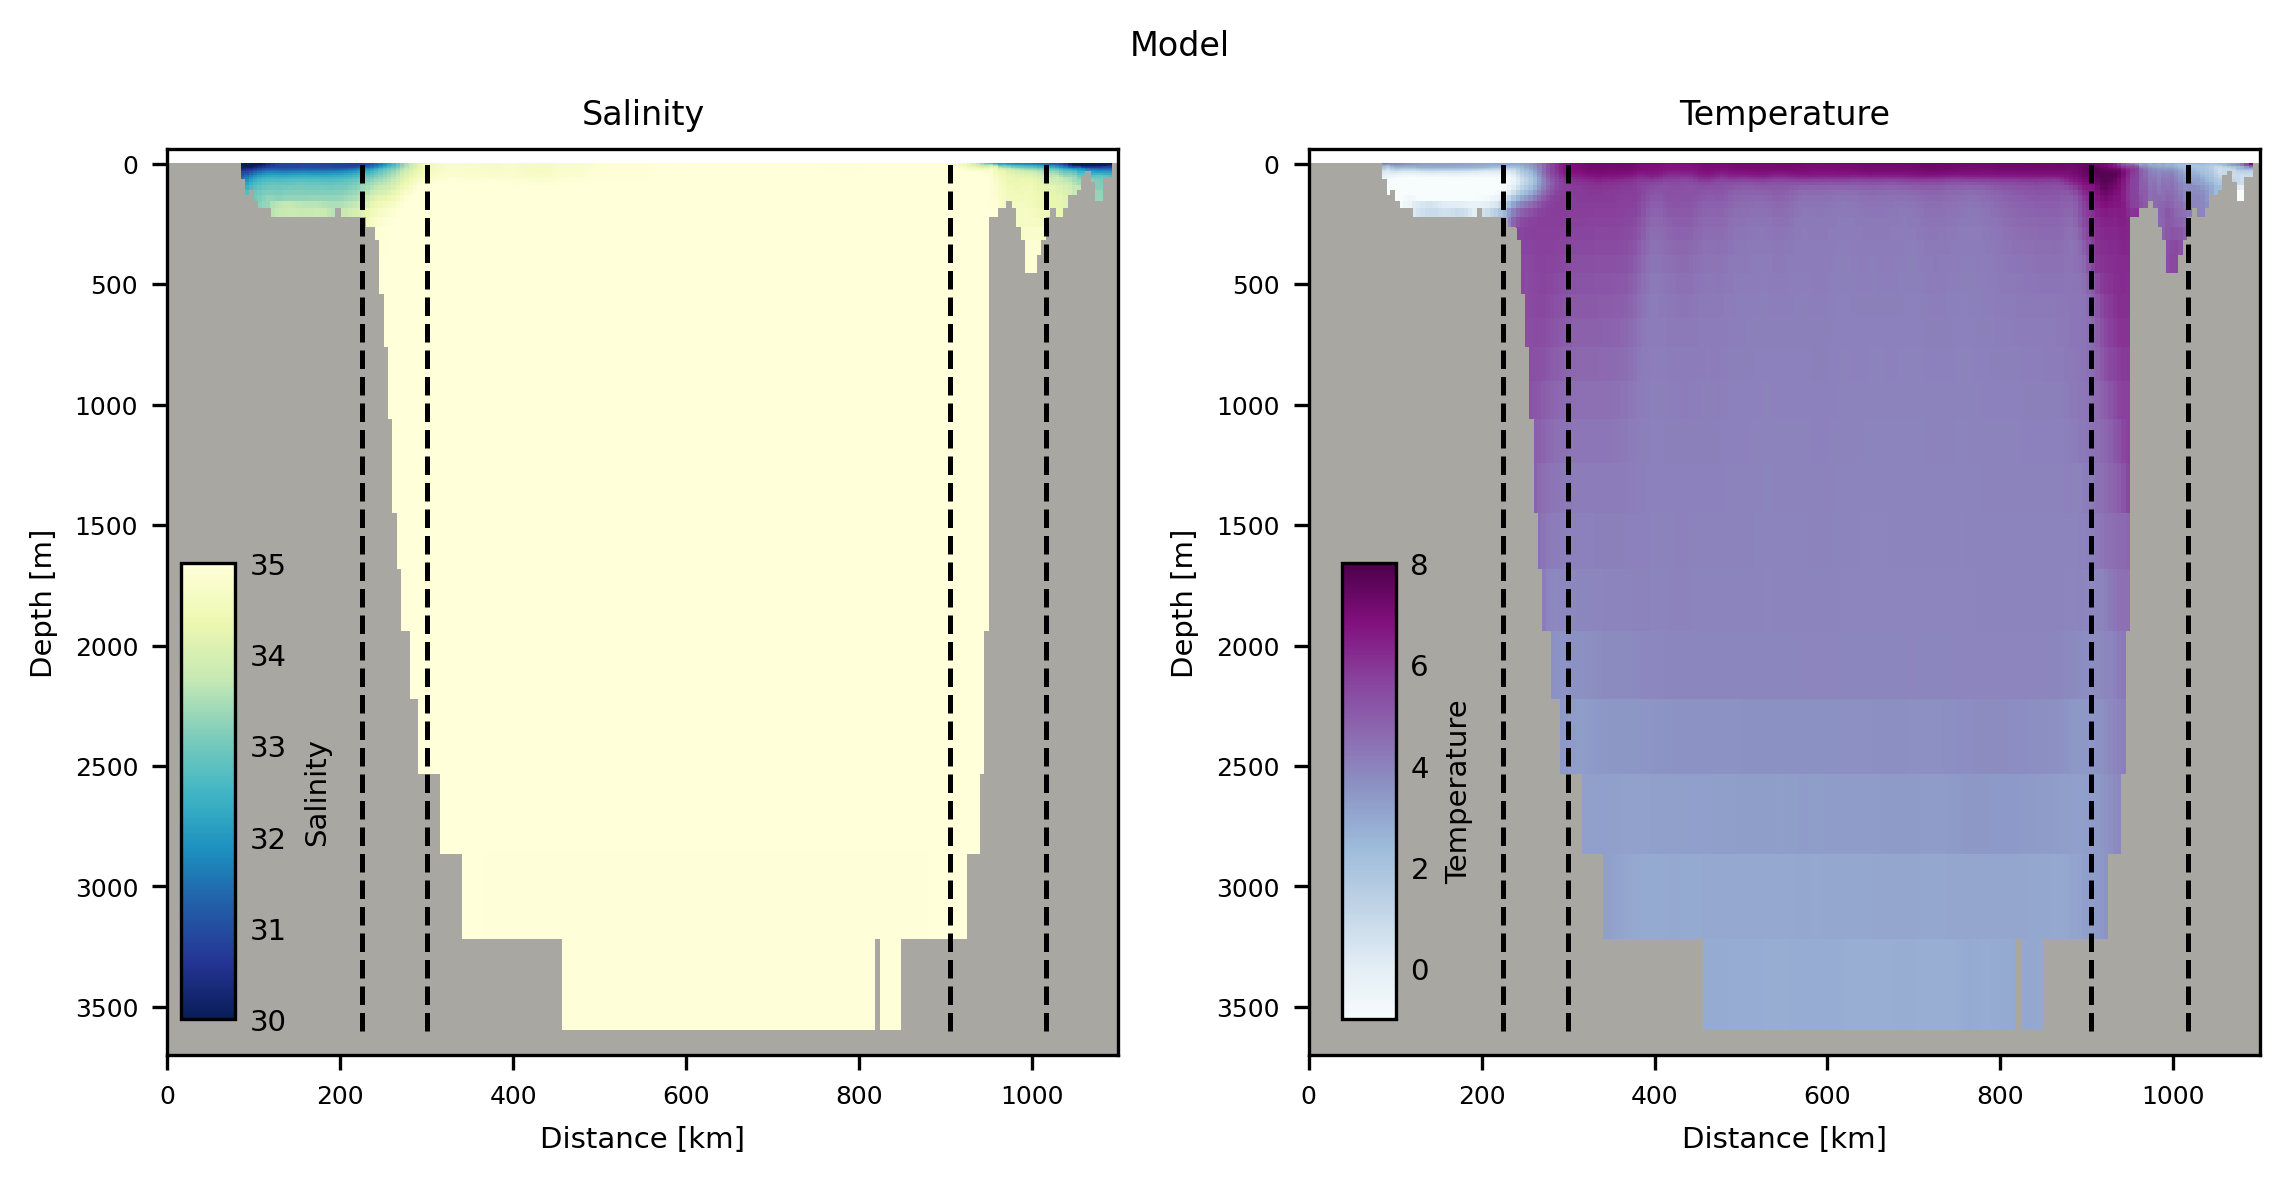

In [124]:
fig, ax = plt.subplots(1,2, figsize=(9, 4), dpi=300)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(3700, -60)
    axis.set_xlim(0, 1100)
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlabel('Distance [km]', fontsize=7)
    axis.set_ylabel('Depth [m]', fontsize=7)
    axis.plot([S_distance[45],S_distance[45]],[3600,0], '--k', linewidth=1.2)
    axis.plot([S_distance[60],S_distance[60]],[3600,0], '--k', linewidth=1.2)
    axis.plot([S_distance[180],S_distance[180]],[3600,0], '--k', linewidth=1.2)
    axis.plot([S_distance[202],S_distance[202]],[3600,0], '--k', linewidth=1.2)
    
ax[0].set_title('Salinity', fontsize=8)
ax[1].set_title('Temperature', fontsize=8)
fig.suptitle('Model', fontsize=8)

# plot model boundary condition:
bdy_cell = 0
xx, zz = np.meshgrid(S_distance, depths)
CB1 = ax[0].pcolormesh(xx, zz, bdy_sal[:,bdy_cell,:], vmin=30, vmax=35, cmap=matplotlib.cm.get_cmap('YlGnBu_r'))
ax[0].pcolormesh(xx, zz, dPb_S_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))

# plot T, S for model
xx, zz = np.meshgrid(S_distance, depths)
CB2 = ax[1].pcolormesh(xx, zz, bdy_temp[:,bdy_cell,:], vmin=-1, vmax=8, cmap=matplotlib.cm.get_cmap('BuPu'))
ax[1].pcolormesh(xx, zz, dPb_S_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))

cbaxes = fig.add_axes([0.13, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB1, ax=ax[1], cax=cbaxes); 
CBar.set_label('Salinity', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

cbaxes = fig.add_axes([0.56, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB2, ax=ax[1], cax=cbaxes); 
CBar.set_label('Temperature', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

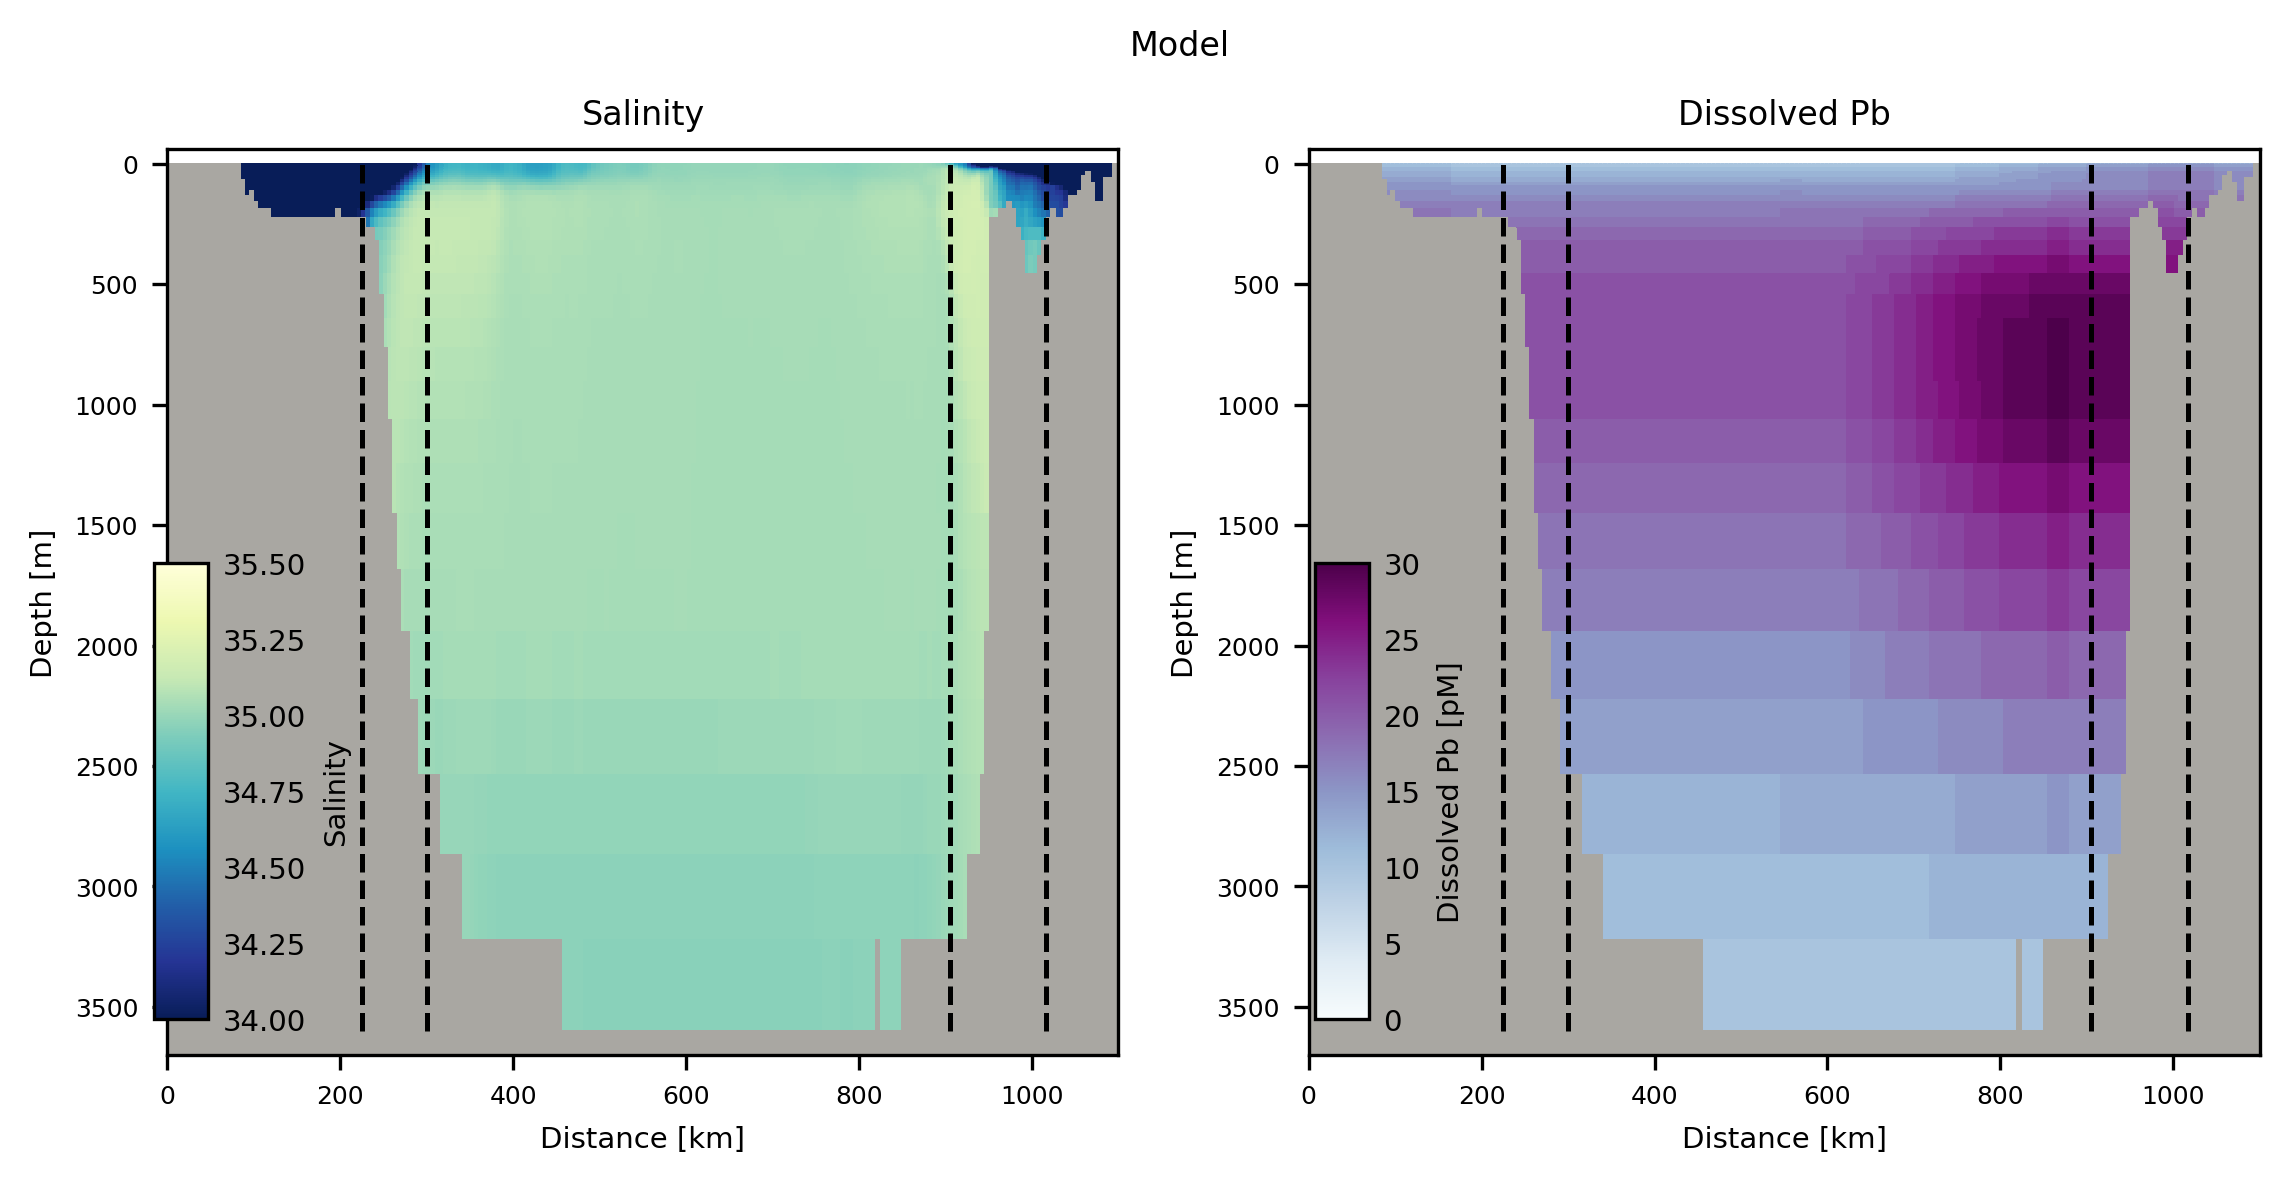

In [24]:
fig, ax = plt.subplots(1,2, figsize=(9, 4), dpi=300)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(3700, -60)
    axis.set_xlim(0, 1100)
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlabel('Distance [km]', fontsize=7)
    axis.set_ylabel('Depth [m]', fontsize=7)
    axis.plot([S_distance[45],S_distance[45]],[3600,0], '--k', linewidth=1.2)
    axis.plot([S_distance[60],S_distance[60]],[3600,0], '--k', linewidth=1.2)
    axis.plot([S_distance[180],S_distance[180]],[3600,0], '--k', linewidth=1.2)
    axis.plot([S_distance[202],S_distance[202]],[3600,0], '--k', linewidth=1.2)
    
ax[0].set_title('Salinity', fontsize=8)
ax[1].set_title('Dissolved Pb', fontsize=8)
fig.suptitle('Model', fontsize=8)

# plot model boundary condition:
bdy_cell = 0
xx, zz = np.meshgrid(S_distance, depths)
CB1 = ax[0].pcolormesh(xx, zz, bdy_sal[:,bdy_cell,:], vmin=34, vmax=35.5, cmap=matplotlib.cm.get_cmap('YlGnBu_r'))
ax[0].pcolormesh(xx, zz, dPb_S_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))

# plot T, S for model
xx, zz = np.meshgrid(S_distance, depths)
CB2 = ax[1].pcolormesh(xx, zz, dPb_S[:,bdy_cell,:]*1e12, vmin=0, vmax=30, cmap=matplotlib.cm.get_cmap('BuPu'))
ax[1].pcolormesh(xx, zz, dPb_S_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))

cbaxes = fig.add_axes([0.12, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB1, ax=ax[1], cax=cbaxes); 
CBar.set_label('Salinity', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

cbaxes = fig.add_axes([0.55, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB2, ax=ax[1], cax=cbaxes); 
CBar.set_label('Dissolved Pb [pM]', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

#### Create new boundary condition starting from T-S diagram:

In [43]:
dPb_S_new = np.copy(dPb_S)*0.7
# dPb_S_new[dPb_S > 1.5e-11] = 1.5e-11
dPb_S_new[(bdy_sal > 34.8) & (bdy_temp < 4.5)] = 3e-12
# dPb_S_new[(bdy_sal > 34.0) & (bdy_temp > 5.5)] = 2e-11
dPb_S_new[(bdy_sal > 34.3) & (bdy_temp > 7.0)] = 3e-11

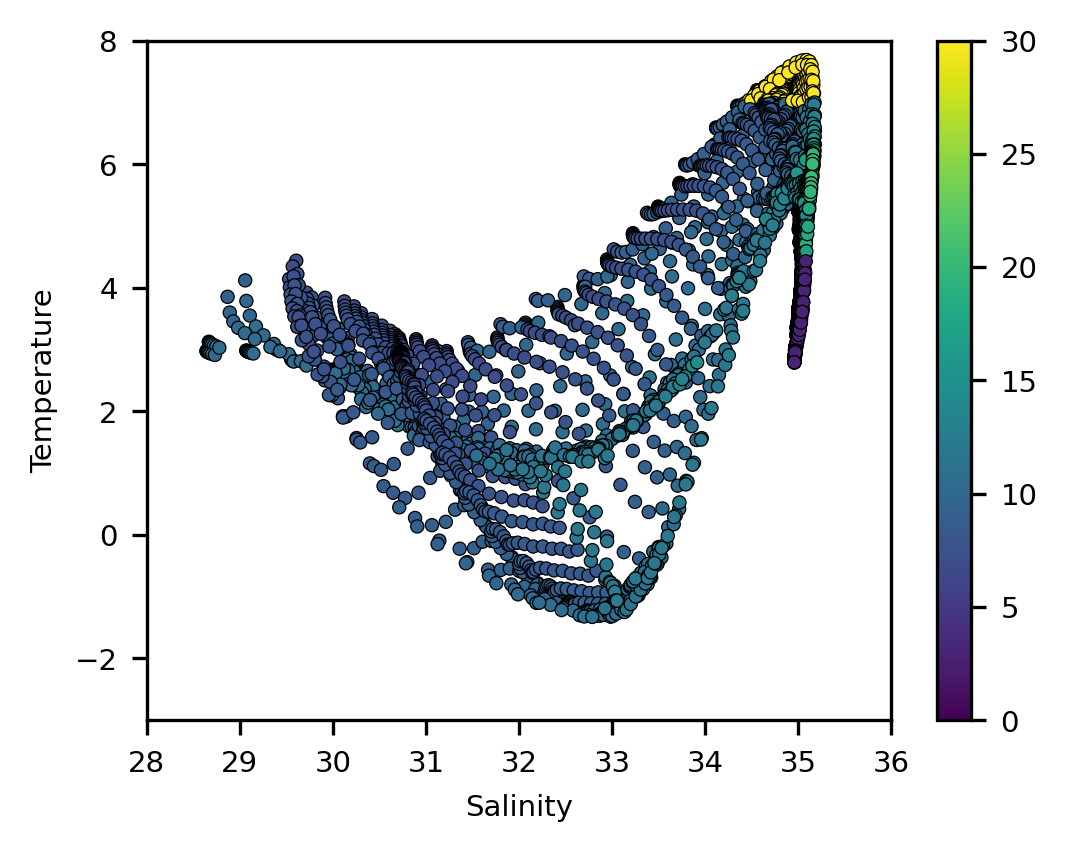

In [44]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=300)

CB = ax.scatter(bdy_sal[:,-1,:], bdy_temp[:,-1,:], c=dPb_S_new[:,-1,:]*1e12, \
                vmin=0, vmax=30, s=10, edgecolor='k', linewidth=0.3)

ax.set_xlim(28, 36)
ax.set_ylim(-3, 8)
ax.set_xlabel('Salinity', fontsize=7)
ax.set_ylabel('Temperature', fontsize=7)
ax.tick_params(axis='both', labelsize=7)

CBar1 = plt.colorbar(CB)
CBar1.ax.tick_params(labelsize=7) 